In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import optuna
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns

In [25]:
# Read in formatted dataset
# assume repo root is two levels up from this notebook
ROOT = Path.cwd().parents[1]  # adjust if needed
DATA_DIR = ROOT / "data"

print(DATA_DIR)

print(ROOT)

df = pd.read_parquet(r"../../data/processed_pitches_df_2025-03-30_2025-09-30.parquet")


/Users/matthewgillies/PitchArsenalModelling/data
/Users/matthewgillies/PitchArsenalModelling


In [26]:
df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,usage,p_throws,velo,VAA,...,dist_std,pct_high,pct_outside,seq_dist_mean,x_signed_offset,z_signed_offset,xz_correlation,HB,IVB,arsenal_size
0,434378,CH,2025,213,0.282828,0.262911,0.084223,R,84.638028,-5.074375,...,0.691211,0.446009,0.680751,1.470908,-0.527887,-0.226479,NaN,-13.056901,9.394366,5
1,434378,CU,2025,371,0.268116,0.396226,0.146698,R,78.436927,-5.273957,...,0.643361,0.347709,0.649596,1.403546,0.020863,-0.376631,NaN,7.577143,-12.39752,5
2,434378,FF,2025,1139,0.143376,0.240562,0.450376,R,93.914574,-4.365087,...,0.570782,0.748903,0.653205,1.220969,0.015154,0.544434,NaN,-8.932256,18.667217,5
4,434378,SL,2025,597,0.310850,0.281407,0.236062,R,87.111223,-5.450351,...,0.637569,0.251256,0.621441,1.187801,0.415427,-0.575578,NaN,4.043015,5.519598,5
5,434378,ST,2025,195,0.277778,0.256410,0.077106,R,80.774359,-4.965142,...,0.664469,0.425641,0.728205,1.432101,0.661282,-0.210615,NaN,11.527385,-1.301538,5


In [27]:
df.shape

(2839, 45)

In [28]:
df.isna().sum().sort_values(ascending=False)

xz_correlation        2839
dist_std                 2
pitch_type               2
z_std                    2
seq_dist_mean            2
x_std                    2
spin                     2
below_zone_rate          1
mean_x_dist_center       1
edge_rate                1
mean_z_dist_mid          1
z_mean                   1
x_mean                   1
pct_high                 1
x_range                  1
z_range                  1
pct_in_zone              1
zbin_high_rate           1
pct_on_edge              1
zbin_low_rate            1
dist_mean                1
above_zone_rate          1
pct_outside              1
rel_z                    1
rel_x                    1
ext                      1
HAA                      1
VAA                      1
velo                     1
x_signed_offset          1
z_signed_offset          1
HB                       1
IVB                      1
pitcher                  0
arm_side_rate            0
glove_side_rate          0
zbin_mid_rate            0
p

In [29]:
# drop nas -> not a large proportion
# df = df.dropna()

In [30]:
df.shape

(2839, 45)

In [31]:
# drop duplicates in pitcher/season/pitch_type
df = df.drop_duplicates(subset=["pitcher", "season", "pitch_type"])
df.shape

(2839, 45)

In [32]:
# filter to FF only for initial analysis
ff_df = df[df["pitch_type"] == "SL"]

# filter to min 60 pitches thrown
ff_filtered = ff_df[ff_df['pitches'] > 60]

In [33]:
ff_df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,usage,p_throws,velo,VAA,...,dist_std,pct_high,pct_outside,seq_dist_mean,x_signed_offset,z_signed_offset,xz_correlation,HB,IVB,arsenal_size
4,434378,SL,2025,597,0.310850,0.281407,0.236062,R,87.111223,-5.450351,...,0.637569,0.251256,0.621441,1.187801,0.415427,-0.575578,NaN,4.043015,5.519598,5
9,445276,SL,2025,53,0.230769,0.226415,0.061700,R,83.926415,-4.847764,...,0.578429,0.188679,0.641509,1.13403,0.073019,-0.635472,NaN,7.100377,-3.101887,3
33,453286,SL,2025,319,0.301020,0.294671,0.236823,R,86.377116,-3.773036,...,0.598600,0.269592,0.667712,1.282669,0.363699,-0.477367,NaN,3.716614,3.812163,4
44,458677,SL,2025,271,0.340278,0.265683,0.327690,L,87.975646,-4.912531,...,0.682411,0.188192,0.645756,1.302285,-0.337528,-0.769041,NaN,-2.12059,2.951734,4
50,471911,SL,2025,186,0.316456,0.311828,0.251691,R,84.330108,-4.147259,...,0.633328,0.231183,0.736559,1.351038,0.343226,-0.524032,NaN,2.369032,4.095484,5


In [34]:
ff_df.shape

(458, 45)

In [35]:
# plot top 10 correlations with whiff_rate
correlations = ff_filtered.select_dtypes("number").corr()["whiff_pct"].abs().sort_values(ascending=False
)
top_10_features = correlations.index[1:11]  # exclude whiff_rate itself
print("Top 10 features correlated with whiff_rate:")
print(top_10_features)

Top 10 features correlated with whiff_rate:
Index(['csw_pct', 'dist_mean', 'mean_z_dist_mid', 'zbin_mid_rate',
       'below_zone_rate', 'zbin_low_rate', 'pct_in_zone', 'dist_std',
       'z_signed_offset', 'z_mean'],
      dtype='object')


In [36]:
# create correlation heatmap for features with traget (whiff_pct)
# import seaborn as sns
# corr = ff_df.select_dtypes(include=[np.number]).corr()
# plt.figure(figsize=(24, 24))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [37]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    model_type = trial.suggest_categorical(
        "model_type", ["xgboost", "lightgbm", "random_forest"]
    )

    if model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("xgb_n_estimators", 200, 2000),
            "max_depth": trial.suggest_int("xgb_max_depth", 3, 12),
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
            "min_child_weight": trial.suggest_float("xgb_min_child_weight", 1e-3, 50.0, log=True),
            "gamma": trial.suggest_float("xgb_gamma", 0.0, 10.0),
            "reg_alpha": trial.suggest_float("xgb_reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("xgb_reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = XGBRegressor(**params)

    elif model_type == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("lgb_n_estimators", 200, 5000),
            "learning_rate": trial.suggest_float("lgb_learning_rate", 0.005, 0.3, log=True),
            "num_leaves": trial.suggest_int("lgb_num_leaves", 16, 512),
            "max_depth": trial.suggest_int("lgb_max_depth", -1, 16),
            "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 200),
            "subsample": trial.suggest_float("lgb_subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("lgb_reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("lgb_reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1,
        }
        model = LGBMRegressor(**params)

    else:  # random_forest
        params = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 200, 2000),
            "max_depth": trial.suggest_int("rf_max_depth", 2, 50),
            "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 20),
            "max_features": trial.suggest_categorical("rf_max_features", ["sqrt", "log2", 0.5, 1.0]),
            "bootstrap": trial.suggest_categorical("rf_bootstrap", [True, False]),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = RandomForestRegressor(**params)

    # Fit
    if model_type == "catboost":
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=False)
    else:
        model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_valid)
    rmse = float(np.sqrt(mean_squared_error(y_valid, y_pred)))
    return rmse



In [38]:
# develop base xgboost workflow 
cat_cols = ['p_throws'] + [col for col in ff_df.columns if col.startswith('has_')]

target = "whiff_pct"

# 1) train/val split by pitcher - when we have multiple seasons with same pitches
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ff_df, groups=ff_df["pitcher"]))

train = ff_df.iloc[train_idx].copy()
val   = ff_df.iloc[val_idx].copy()

# 2) choose features (exclude ids + targets)
drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns])

y_train = train[target].values
y_val   = val[target].values

# 3) one-hot categorical cols (simple + reliable)
X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val, columns=cat_cols, dummy_na=True)

# align columns
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)

# 4) sample weights to reflect stability of rate targets
w_train = train["pitches"].values  # or np.sqrt(train["pitches"].values)



study = optuna.create_study(direction="minimize") 
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  RMSE: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-31 19:02:50,785] A new study created in memory with name: no-name-d8e2dc08-dd95-4dc8-95c0-ee1ca468eb4a
[I 2026-01-31 19:02:52,543] Trial 0 finished with value: 0.08326399708567536 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 1181, 'rf_max_depth': 31, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 9, 'rf_max_features': 'log2', 'rf_bootstrap': True}. Best is trial 0 with value: 0.08326399708567536.
[I 2026-01-31 19:02:52,965] Trial 1 finished with value: 0.0911511645808231 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 282, 'rf_max_depth': 7, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 17, 'rf_max_features': 1.0, 'rf_bootstrap': False}. Best is trial 0 with value: 0.08326399708567536.
[I 2026-01-31 19:02:54,240] Trial 2 finished with value: 0.08874614767201057 and parameters: {'model_type': 'lightgbm', 'lgb_n_estimators': 2652, 'lgb_learning_rate': 0.1237147404446087, 'lgb_num_leaves': 162, 'lgb_max_depth': -1, 'lgb_min_child_

Best trial:
  RMSE: 0.0822569229075767
  Params: 
    model_type: random_forest
    rf_n_estimators: 1321
    rf_max_depth: 38
    rf_min_samples_split: 19
    rf_min_samples_leaf: 10
    rf_max_features: 0.5
    rf_bootstrap: True


In [39]:
trial.params

{'model_type': 'random_forest',
 'rf_n_estimators': 1321,
 'rf_max_depth': 38,
 'rf_min_samples_split': 19,
 'rf_min_samples_leaf': 10,
 'rf_max_features': 0.5,
 'rf_bootstrap': True}

In [41]:
# define model with best params
best_params = trial.params

if best_params['model_type']=='xgboost':
    best_params = {k.replace('xgb_',''):v for k,v in best_params.items() if k.startswith('xgb_')}
    model = XGBRegressor(**best_params, random_state=42)
elif best_params['model_type']=='lightgbm':
    best_params = {k.replace('lgb_',''):v for k,v in best_params.items() if k.startswith('lgb_')}
    model = LGBMRegressor(**best_params, random_state=42)
elif best_params['model_type']=='random_forest':
    best_params = {k.replace('rf_',''):v for k,v in best_params.items() if k.startswith('rf_')}
    model = RandomForestRegressor(**best_params, random_state=42)

model.fit(X_train, y_train)

# train metrics:

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)
print("Train RMSE:", train_rmse, "R2:", train_r2)

pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)

print("RMSE:", rmse, "R2:", r2)

Train RMSE: 0.06885912785591619 R2: 0.5668282515296215
RMSE: 0.0822569229075767 R2: 0.39086638299216103


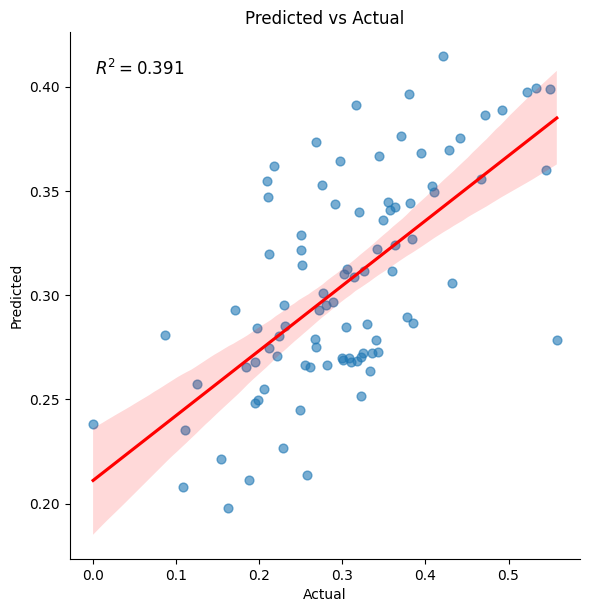

In [ ]:
# seaborn lmplot of predicted vs actual
# Build plotting dataframe
plot_df = pd.DataFrame({
    "actual": y_val,
    "predicted": pred
})

# Plot
g = sns.lmplot(
    data=plot_df,
    x="actual",
    y="predicted",
    height=6,
    aspect=1,
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"color": "red"}
)

# Annotate R^2
plt.text(
    0.05, 0.95,
    f"$R^2 = {r2:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")

plt.show()



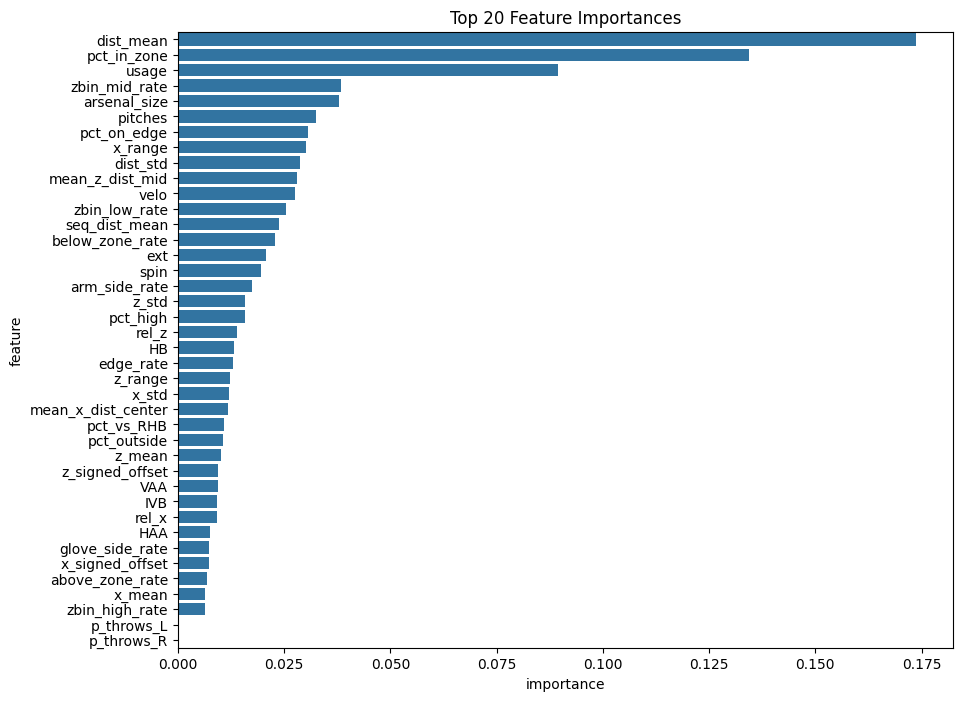

In [44]:
# plot feature importance
importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(40))
plt.title("Top 20 Feature Importances")
plt.show()

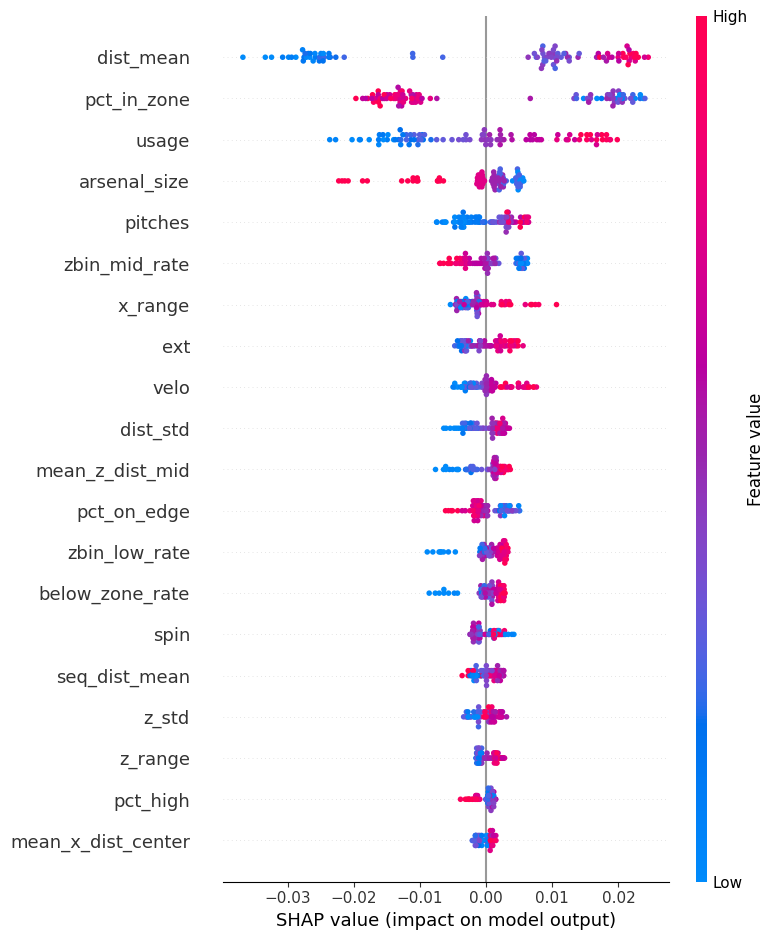

In [45]:
# shap explainer and summary plot
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

# Workflow to look at individual player predictions

In [46]:
from pybaseball import playerid_lookup

def get_mlbam_id(first: str, last: str) -> int:
    """
    Returns MLBAM id (key_mlbam) for a player name.
    If multiple results, returns the first row (you can disambiguate by birth year if needed).
    """
    res = playerid_lookup(last, first)
    if res.empty:
        raise ValueError(f"No player found for {first} {last}")

    # key_mlbam is what Statcast 'pitcher' column uses
    mlbam = res.iloc[0]["key_mlbam"]
    if pd.isna(mlbam):
        raise ValueError(f"Found player but no MLBAM id for {first} {last}")

    return int(mlbam)

# Example:
pitcher_id = get_mlbam_id("Gerrit", "Cole")
pitcher_id


543037

In [47]:
import pandas as pd

def preprocess_single_row(row_df, cat_cols, model_columns):
    """
    Preprocess a single-row dataframe to match X_train exactly.
    """
    X = row_df.copy()

    # ensure categoricals are strings and fill NA
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype("string").fillna("NONE")

    # one-hot encode
    X = pd.get_dummies(X, columns=cat_cols, dummy_na=True)

    # align columns to training matrix
    X = X.reindex(columns=model_columns, fill_value=0)

    return X



In [48]:
import shap
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup

def explain_one_prediction(
    features_df,
    model,
    model_columns,
    cat_cols,
    first,
    last,
    season,
    pitch_type="FF"
):
    # --- lookup MLBAM id ---
    pid_df = playerid_lookup(last, first)
    if pid_df.empty:
        raise ValueError(f"No player found for {first} {last}")

    pitcher_id = int(pid_df.iloc[0]["key_mlbam"])

    # --- select row ---
    row = features_df[
        (features_df["pitcher"] == pitcher_id) &
        (features_df["season"] == season) &
        (features_df["pitch_type"] == pitch_type)
    ].copy()

    if row.empty:
        raise ValueError(f"No row for {first} {last}, {season}, {pitch_type}")

    # if somehow duplicated, take most-used
    if len(row) > 1:
        row = row.loc[[row["pitches"].idxmax()]]

    # --- drop non-features (exactly like training) ---
    drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
    X_pre = row.drop(columns=[c for c in drop_cols if c in row.columns])

    # --- preprocess to match model ---
    X_row = preprocess_single_row(
        X_pre,
        cat_cols=cat_cols,
        model_columns=model_columns
    )

    # --- prediction ---
    pred = float(model.predict(X_row)[0])

    # --- SHAP ---
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_row)

    # Waterfall plot (best for single prediction)
    shap.plots.waterfall(shap_values[0], max_display=20)

    return {
        "pitcher_id": pitcher_id,
        "season": season,
        "pitch_type": pitch_type,
        "prediction": pred,
        "raw_row": row,
        "X_row": X_row,
        "shap_values": shap_values
    }



In [49]:
# Get pitchers from X_val:

val.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,usage,p_throws,velo,VAA,...,dist_std,pct_high,pct_outside,seq_dist_mean,x_signed_offset,z_signed_offset,xz_correlation,HB,IVB,arsenal_size
4,434378,SL,2025,597,0.310850,0.281407,0.236062,R,87.111223,-5.450351,...,0.637569,0.251256,0.621441,1.187801,0.415427,-0.575578,NaN,4.043015,5.519598,5
122,518489,SL,2025,129,0.349206,0.294574,0.344920,R,85.327907,-4.458728,...,0.703858,0.170543,0.666667,1.336257,0.501860,-0.841008,NaN,5.39907,2.316279,4
133,518876,SL,2025,184,0.288660,0.228261,0.066909,R,85.747283,-4.126201,...,0.685028,0.081522,0.809783,1.115751,0.863967,-0.848207,NaN,2.10587,3.319565,6
164,521230,SL,2025,77,0.550000,0.363636,0.331897,R,86.192208,-4.426832,...,0.728468,0.168831,0.818182,1.296476,0.918961,-0.792857,NaN,2.364156,3.333506,2
240,543518,SL,2025,70,0.363636,0.242857,0.235690,R,86.434286,-4.418036,...,0.608092,0.2,0.728571,1.037907,0.603714,-0.701571,NaN,4.491429,2.477143,3


In [50]:
# get playerr name from id: 
from pybaseball import playerid_reverse_lookup

# single id
for i in range(len(val)):
    print(val.iloc[i])
    print(playerid_reverse_lookup([val['pitcher'].iloc[i]], key_type="mlbam")[['name_first', 'name_last']])


pitcher                    434378
pitch_type                     SL
season                       2025
pitches                       597
whiff_pct                 0.31085
csw_pct                  0.281407
usage                    0.236062
p_throws                        R
velo                    87.111223
VAA                     -5.450351
HAA                      2.406433
ext                      6.015075
spin                  2501.149079
rel_x                   -1.874657
rel_z                    7.074154
pct_vs_RHB               0.462312
above_zone_rate          0.023451
below_zone_rate          0.442211
zbin_low_rate            0.442211
zbin_mid_rate            0.534338
zbin_high_rate           0.023451
glove_side_rate          0.174204
arm_side_rate            0.147404
edge_rate                0.123953
mean_z_dist_mid          0.922781
mean_x_dist_center        0.56933
x_mean                   0.415427
z_mean                   1.874422
x_std                    0.574246
z_std         

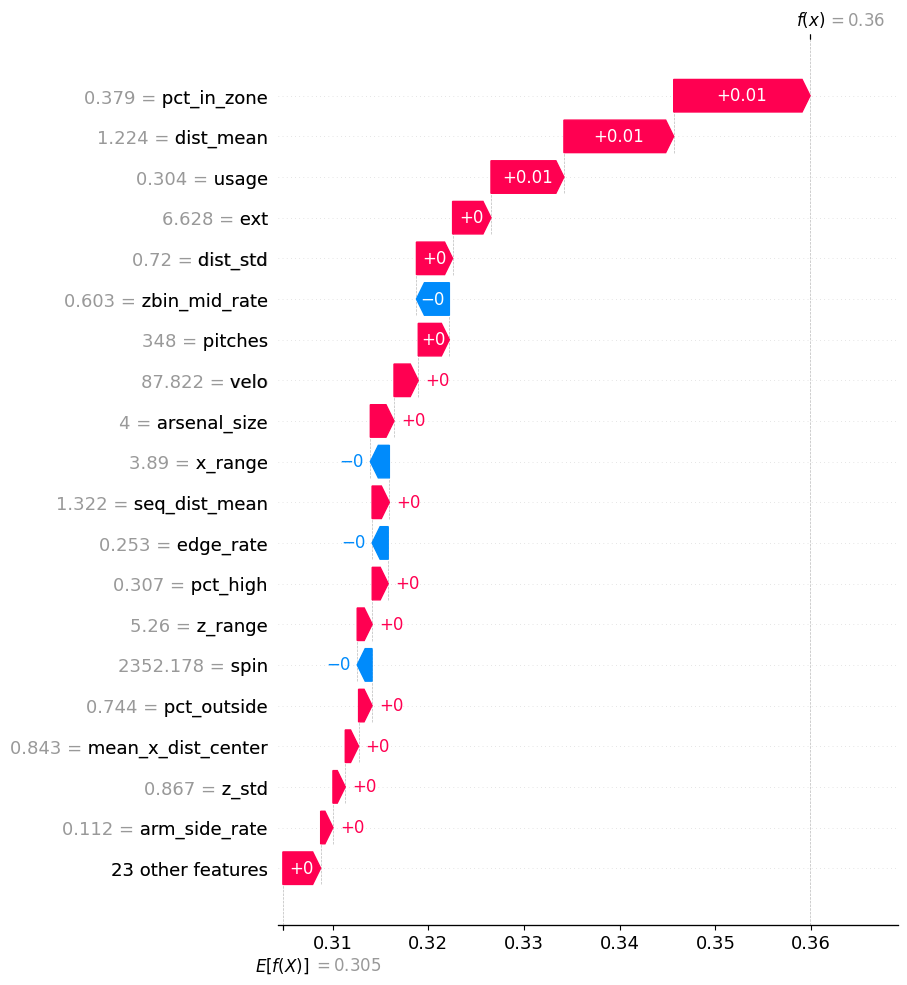

Predicted SL whiff%: 0.3598844204678671


,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,usage,p_throws,velo,VAA,...,dist_std,pct_high,pct_outside,seq_dist_mean,x_signed_offset,z_signed_offset,xz_correlation,HB,IVB,arsenal_size
3541,686218,SL,2025,348,0.415385,0.37069,0.303665,R,87.821552,-3.643887,...,0.720244,0.307471,0.744253,1.321913,0.760115,-0.466149,NaN,3.484138,3.89069,4


In [51]:
model_columns = X_train.columns

out = explain_one_prediction(
    features_df=df,   # your full season-level table
    model=model,
    model_columns=model_columns,
    cat_cols=cat_cols,
    first="Emmet",
    last="Sheehan",
    season=2025,
    pitch_type="SL"
)

print("Predicted SL whiff%:", out["prediction"])
out["raw_row"]
